## Train Classifier to recognise buildings from Sentinel rgb imagery

### 1 - Import and display training building footprints

In [2]:
# Import packages - Needs utils.py and unet.py in current directory
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf

import descarteslabs as dl
import descarteslabs.workflows as wf
from descarteslabs.vectors import FeatureCollection, properties as p

from utils import make_ground_dataset_from_polygons, get_center_location
from unet import UNet

In [1]:
# Import Geojson - to FeatureCollection?
with open("./sanFranBuildings.geojson") as f:
    fc = json.load(f)
print('Number of buildings:', len(fc['features']))

FileNotFoundError: [Errno 2] No such file or directory: './sanFranBuildings.geojson'

### 2 - Get corresponding imagery for building footprints

In [5]:
# Get corresponding imagery for all polygons
n_samples = make_ground_dataset_from_polygons('sanFranBuildings.geojson',
                                              products='sentinel-2:L1C',
                                              bands=['red green blue'],
                                              resolution=10,
                                              tilesize=64,
                                              pad=0,
                                              start_datetime='2021-01-06',
                                              end_datetime='2021-01-11',
                                              out_file='sanfranrgb.tfrecords')

Caught exception for lat: 37.78498996185687 and lon: -122.41415961046533 - <PIL.TiffImagePlugin.TiffImageFile image mode=L size=64x64 at 0x7FDF8623E850> has type TiffImageFile, but expected one of: int, long, float
Caught exception for lat: 37.78498996185687 and lon: -122.41415961046533 - <PIL.TiffImagePlugin.TiffImageFile image mode=L size=64x64 at 0x7FDF861D08D0> has type TiffImageFile, but expected one of: int, long, float
Caught exception for lat: 37.78498996185687 and lon: -122.41415961046533 - [Errno 2] No such file or directory: 'tmp.tiff'
Caught exception for lat: 37.776539140402136 and lon: -122.420812123096 - [Errno 2] No such file or directory: 'tmp.tiff'
Caught exception for lat: 37.776539140402136 and lon: -122.420812123096 - [Errno 2] No such file or directory: 'tmp.tiff'
Caught exception for lat: 37.776539140402136 and lon: -122.420812123096 - [Errno 2] No such file or directory: 'tmp.tiff'
Caught exception for lat: 37.768981208975106 and lon: -122.42387479246015 - [Errn

In [6]:
# Define the features in the TFRecords file
features = {
    'image/image_data': tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channels': tf.io.FixedLenFeature([], tf.int64),
    'target/target_data': tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
    'target/height': tf.io.FixedLenFeature([], tf.int64),
    'target/width': tf.io.FixedLenFeature([], tf.int64),
    'target/channels': tf.io.FixedLenFeature([], tf.int64),
    'dltile': tf.io.FixedLenFeature([], tf.string)
}


In [7]:
def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)
    
    img_height = tf.cast(image_features['image/height'], tf.int32)
    img_width = tf.cast(image_features['image/width'], tf.int32)
    img_channels = tf.cast(image_features['image/channels'], tf.int32)
    
    target_height = tf.cast(image_features['target/height'], tf.int32)
    target_width = tf.cast(image_features['target/width'], tf.int32)
    target_channels = tf.cast(image_features['target/channels'], tf.int32)
    
    image_raw = tf.reshape(tf.squeeze(image_features['image/image_data']),
                           tf.stack([img_height, img_width, img_channels]))
    
    target_raw = tf.reshape(tf.squeeze(image_features['target/target_data']),
                            tf.stack([target_height, target_width, target_channels]))
    
    return image_raw, target_raw

In [8]:
# Create a TFRecordDataset to read images from these TFRecords
data = tf.data.TFRecordDataset('sanfranrgb.tfrecords') \
           .map(parse_example, num_parallel_calls=4)

data_viz = iter(data.batch(1))

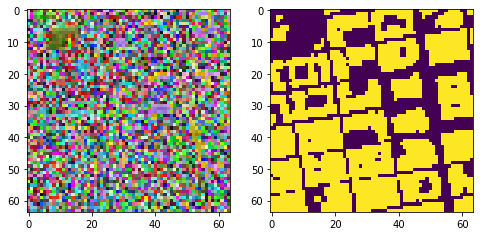

In [11]:
# Visualize samples. You can re-run this cell to iterate through the dataset.
img, trg = next(data_viz)
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(img.numpy().astype(np.uint8)[0])
ax[1].imshow(trg.numpy().astype(np.uint8)[0].squeeze())

### 3 - Train Classifier

In [12]:
# Build the model. We could just use the base_model but then the input size would be fixed
# once we load a saved model. In order to be able to predict on larger tiles we create an
# input layer with no fixed size
base_model = UNet()
inputs = tf.keras.layers.Input(shape=(None, None, 3))
model = tf.keras.Model(inputs=inputs, outputs=base_model(inputs))

In [13]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
u_net (UNet)                 (None, None, None, 1)     7760097   
Total params: 7,760,097
Trainable params: 7,760,097
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Define some transforms
def subtract_mean(feature, target):
    return feature - 128.0, target

def type_transform(feature, target):
    return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)

In [15]:
# Train/val/test data
transforms = [type_transform, subtract_mean]
batch_size = 8
n_samples = 271
n_train_samples = int(0.8*n_samples)
n_val_samples = n_samples - n_train_samples

data = tf.data.TFRecordDataset('sanfranrgb.tfrecords') \
           .map(parse_example, num_parallel_calls=4)

# Apply transforms
for t in transforms:
    data = data.map(t, num_parallel_calls=4)

# Shuffle the data and split into train and validation set
data = data.shuffle(buffer_size=1000)
data_train = data.take(n_train_samples) \
                 .repeat() \
                 .batch(batch_size)
data_val = data.skip(n_train_samples) \
               .repeat() \
               .batch(batch_size)

In [16]:
# Carry out training
history = model.fit(data_train,
                    steps_per_epoch=n_train_samples//batch_size,
                    validation_data=data_val,
                    validation_steps=n_val_samples//batch_size,
                    epochs=100)

Epoch 1/100
27/27 [==============================] - 17s 612ms/step - loss: 11.0607 - accuracy: 0.5630 - val_loss: 6.2115 - val_accuracy: 0.5961
Epoch 2/100
27/27 [==============================] - 16s 594ms/step - loss: 5.5899 - accuracy: 0.5828 - val_loss: 4.9851 - val_accuracy: 0.5606
Epoch 3/100
27/27 [==============================] - 16s 583ms/step - loss: 4.3215 - accuracy: 0.5889 - val_loss: 3.5228 - val_accuracy: 0.6062
Epoch 4/100
27/27 [==============================] - 16s 592ms/step - loss: 3.5499 - accuracy: 0.6007 - val_loss: 3.1938 - val_accuracy: 0.6271
Epoch 5/100
27/27 [==============================] - 16s 592ms/step - loss: 2.8752 - accuracy: 0.6326 - val_loss: 2.5246 - val_accuracy: 0.6497
Epoch 6/100
27/27 [==============================] - 16s 581ms/step - loss: 2.2834 - accuracy: 0.6719 - val_loss: 1.8805 - val_accuracy: 0.6972
Epoch 7/100
27/27 [==============================] - 17s 618ms/step - loss: 2.4853 - accuracy: 0.6446 - val_loss: 2.0119 - val_accuracy

In [17]:
# Save the model
tf.saved_model.save(model, 'rgb_model_data/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: rgb_model_data/assets


In [24]:
!zip -r rgb_model_data.zip rgb_model_data
print('Upload model to Storage')
storage = dl.Storage()
storage.set_file('sanfranrgb_demo', 'rgb_model_data.zip')
os.remove('rgb_model_data.zip')

  adding: rgb_model_data/ (stored 0%)
  adding: rgb_model_data/saved_model.pb (deflated 92%)
  adding: rgb_model_data/variables/ (stored 0%)
  adding: rgb_model_data/variables/variables.index (deflated 75%)
  adding: rgb_model_data/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: rgb_model_data/assets/ (stored 0%)
Upload model to Storage


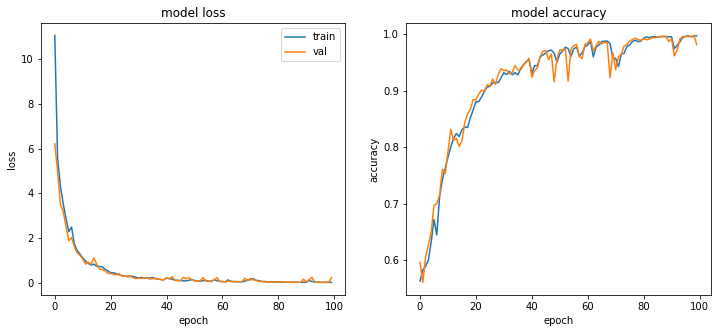

In [20]:
fig, ax = plt.subplots(1, 2,  figsize=(12, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='val')

ax[0].set_title('model loss')
ax[1].set_title('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[0].legend(loc='upper right')

plt.show()

In [21]:
min(history.history['val_loss'])

0.011698304675519466

### 4 - Evaluate model on new area

In [25]:
def load_model_from_storage(storage_key):
    '''Load TF model from DL.Storage'''
    import tempfile
    from tensorflow.keras.models import load_model
    import descarteslabs as dl
    model_zip = tempfile.NamedTemporaryFile()
    model_dir = tempfile.TemporaryDirectory()
    dl.Storage().get_file(storage_key, model_zip.name)
    os.system('unzip {} -d {}'.format(model_zip.name, model_dir.name))
    model = load_model(os.path.join(model_dir.name, 'rgb_model_data'))
    model_zip.close()
    model_dir.cleanup()
    
    return model

In [26]:
def get_image(dltile_key):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products="sentinel-2:L1C", start_datetime='2021-01-06', end_datetime='2021-01-10')
    im = sc.mosaic(bands='red green blue', ctx=ctx, bands_axis=-1)
    ids = [scene.properties.id for scene in sc]
    acquired_datetime = sc[-1].properties.date.isoformat() # grab the acquired date from the last scene
    
    metadata = {
        'acquired_datetime': acquired_datetime,
        'ids': ids,
    }
    
    return im, metadata

In [50]:
def get_image_highres(dltile_key):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products="usda:naip:rgbn:v1", start_datetime='2016-01-01', end_datetime='2018-01-01')
    im = sc.mosaic(bands='red green blue', ctx=ctx, bands_axis=-1)
    ids = [scene.properties.id for scene in sc]
    acquired_datetime = sc[-1].properties.date.isoformat() # grab the acquired date from the last scene
    
    metadata = {
        'acquired_datetime': acquired_datetime,
        'ids': ids,
    }
    
    return im, metadata

In [23]:
def predict_image(dltile_key):
    print("Predict on image for dltile {}".format(dltile_key))
    
    # load model
    model = load_model_from_storage('sanfranrgb_demo')
    
    # get imagery
    im, meta = get_image(dltile_key)
    
    # add batch dimension
    im = np.expand_dims(im, axis=0).astype(np.float32)
    
    # pre-process
    im, _ = subtract_mean(im, None)
    
    # predict
    pred = model.predict(im)
    
    # post-process
    pred = np.clip(255 * pred.squeeze(), 0, 255).astype('uint8')
    
    return im, pred, meta

In [81]:
lat, lon = 37.7718, -122.4091
tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=10, tilesize=128, pad=0)

im, pred, meta = predict_image(tile.key)

Predict on image for dltile 128:0:10.0:10:40:3266


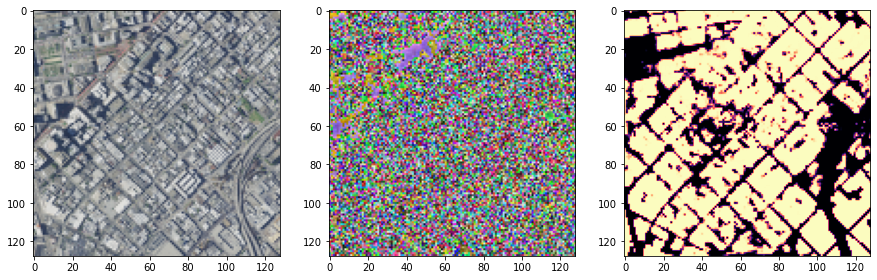

In [82]:
hr, _ = get_image_highres(tile.key)
hr = np.expand_dims(hr, axis=0).astype(np.float32)
hr, _ = subtract_mean(hr, None)

fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].imshow((hr.squeeze()+128).astype('uint8'))
ax[1].imshow((im.squeeze()+128).astype('uint8'))
ax[2].imshow(pred.squeeze(), cmap='magma')

In [2]:
# Visualise on map
m2 = wf.interactive.MapApp()
m2.center = (37.7718, -122.3991)
m2.zoom = 16
geo_json = ipyleaflet.GeoJSON(data=fc,
                   style={'color': 'red', 'fillOpacity': 0.8},
                   hover_style={'fillOpacity': 0.5})
m2.add_layer(geo_json)

img = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2021-01-06', end_datetime='2021-01-10').pick_bands("red green blue")
my_mosaic = img.max(axis='images')
my_mosaic.visualize('image', map=m2)

# Finally, visualize this AOI!
m2

NameError: name 'wf' is not defined